In [1]:
# This notebook contains tests for the `SeismicGeometry` in specific data format
# Data format is specified with the `FORMAT` parameter in the cell number 2
# Note that `FORMAT` must be one of available `SeismicGeometry` data formats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np

sys.path.insert(0, '../../../seismiqb')

from seismiqb import Geometry

In [2]:
""" You should pay attention to the following parameters:

FORMAT : str
    `SeismicGeometry` file format. Possible options are: 'sgy', 'hdf5', 'qhdf5', 'blosc', 'qblosc'.
CUBE_PATH : str
    Path to an existed seismic cube.
DATA_PATH : str
    Path to an original data array.
    It is a path to a file in 'npy', 'sgy', 'hdf5', 'qhdf5', 'blosc' or 'qblosc' data format.
    
Note, this notebook runs tests only for a specified data format.
"""
# Tests parameters
FORMAT = 'sgy'

OUTPUT_DIR = './geometry_test_files'
CUBE_PATH = os.path.join(OUTPUT_DIR, f'test_cube.{FORMAT}')
DATA_PATH = os.path.join(OUTPUT_DIR, 'test_array.npy')

ATTRIBUTES_NAMES = ['snr', 'std_matrix']

LOAD_N_SLIDE = 10
LOAD_N_CROP = 5

BENCHMARK_N_SLIDE = 1000
BENCHMARK_N_CROP = 300

SEED = 42

# Visualization parameters
SCALE = 1
SHOW_FIGURES = True

# Output parameters
VERBOSE = True

In [3]:
# Geometry original data (to check data consistency)
if DATA_PATH.split('.')[-1] == 'npy':
    with open(DATA_PATH, 'rb') as infile:
        data_array = np.load(infile)
else:
    geometry_data = Geometry.new(DATA_PATH)
    data_array = geometry_data[:, :, :]

rng = np.random.default_rng(SEED)

# Tests

In [4]:
%%time
geometry = Geometry.new(CUBE_PATH)

CPU times: user 156 ms, sys: 56.4 ms, total: 213 ms
Wall time: 218 ms


In [5]:
# Check data
geometry_data = geometry[:, :, :]

if not geometry.quantized:
    error_msg = "Check saved and loaded data failed: data is not the same"
    assert np.array_equal(geometry_data, data_array), error_msg
else:
    corr = np.corrcoef(geometry_data.ravel(), data_array.ravel())[0, 1]

    error_msg = "Check saved and loaded data failed: data is not correlated"
    assert corr >= 0.9, error_msg

In [6]:
# Attributes loading

for attribute_name in ATTRIBUTES_NAMES:
    # `__getattr__` test
    attribute = geometry.__getattr__(key=attribute_name)

    error_msg = f"Attributes loading test failed: can't load the `{attribute_name}` with the `__gettattr__` method"
    assert attribute is not None, error_msg

    # `load_attribute` test
    attribute = geometry.load_attribute(src=attribute_name)

    error_msg = f"Attributes loading test failed: can't load the `{attribute_name}` with the `load_attribute` method"
    assert attribute is not None, error_msg

    if VERBOSE:
        print(f"Attribute `{attribute_name}` was successfully loaded")

Attribute `snr` was successfully loaded
Attribute `std_matrix` was successfully loaded


In [7]:
# Slides loading
for axis in range(3):
    for _ in range(LOAD_N_SLIDE):
        index = rng.integers(geometry.shape[axis])
        data_slice = (*[slice(None) for i in range(axis)], index)

        geometry_slide = geometry.load_slide(index=index, axis=axis)
        data_slide = data_array[data_slice]

        if not geometry.quantized:
            error_msg = f"Slide loading test failed: axis={axis}, index={index}."
            assert np.array_equal(geometry_slide, data_slide), error_msg
        else:
            corr = np.corrcoef(geometry_slide.ravel(), data_slide.ravel())[0, 1]

            error_msg = f"Slide loading test failed: axis={axis}, index={index}."
            assert corr >= 0.9, error_msg

In [8]:
# Crops loading
for _ in range(LOAD_N_CROP):
    point = rng.integers(geometry.shape) // 2
    shape = rng.integers((5, 5, 5), high=(200, 200, 200))

    locations = [slice(start_, np.clip(start_ + shape_, 0, max_shape))
                 for start_, shape_, max_shape in zip(point, shape, geometry.shape)]

    geometry_crop = geometry.load_crop(locations=locations)
    data_crop = data_array[locations]

    if not geometry.quantized:
        error_msg = f"Crop loading test failed: locations={locations}."
        assert np.array_equal(geometry_crop, data_crop), error_msg
    else:
        corr = np.corrcoef(geometry_crop.ravel(), data_crop.ravel())[0, 1]

        error_msg = f"Crop loading test failed: locations={locations}."
        assert corr >= 0.9, error_msg

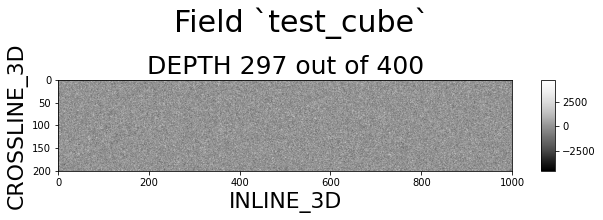

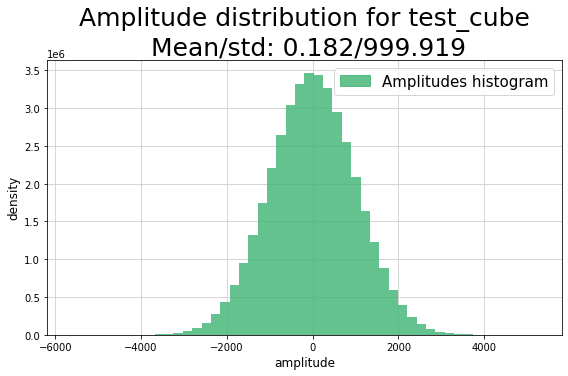

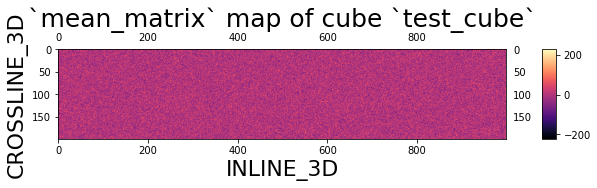

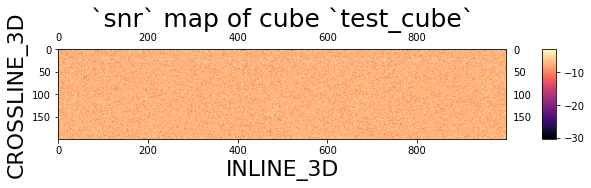

In [9]:
# Visualizations
axis = rng.integers(3)
index = rng.integers(geometry.shape[axis])

geometry.show_slide(index=index, axis=axis, scale=SCALE, show=SHOW_FIGURES)
geometry.show_histogram(hist_log=True, scale=SCALE, show=SHOW_FIGURES)

geometry.show(matrix='mean_matrix', scale=SCALE, show=SHOW_FIGURES)
geometry.show(matrix='snr', scale=SCALE, show=SHOW_FIGURES)

In [10]:
# Timings
timings = geometry.benchmark(n_slides=BENCHMARK_N_SLIDE, n_crops=BENCHMARK_N_CROP, seed=SEED)

for obj, obj_timings in timings.items():
    for timing_name, timing in obj_timings.items():
        timings[obj][timing_name] = round(timing, 3)

timings = {FORMAT.upper(): timings}
timings

{'SGY': {'slide': {'user': 4.69, 'system': 28.87, 'wall': 22.533},
  'crop': {'user': 2.233, 'system': 2.0, 'wall': 1.703}}}